
# Multi-objective Bayesian Optimization


TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
%reset -f
import numpy as np

import torch
from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MOBOGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

import pandas as pd

evaluator = Evaluator(evaluate_TNK)
print(tnk_vocs.dict())

{'variables': {'x1': [0.0, 3.14159], 'x2': [0.0, 3.14159]}, 'constraints': {'c1': ['GREATER_THAN', 0.0], 'c2': ['LESS_THAN', 0.5]}, 'objectives': {'y1': 'MINIMIZE', 'y2': 'MINIMIZE'}, 'constants': {'a': 'dummy_constant'}, 'linked_variables': {}}


In [2]:
generator = MOBOGenerator(tnk_vocs)
generator.options.n_initial = (2,)
generator.options.optim.num_restarts = 1
generator.options.optim.raw_samples = 20

generator.options.acq.proximal_lengthscales = [1.0, 1.0]
X = Xopt(generator=generator, evaluator=evaluator, vocs=tnk_vocs)
X.step()
for i in range(50):
    print(i)
    X.step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [3]:
X.generator.data

,x1,x2,a,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str
1,2.886463,0.156784,dummy_constant,2.886463,0.156784,7.291634,5.813005,"[1, 2, 3]",False,
2,3.121549,1.574565,dummy_constant,3.121549,1.574565,11.186310,8.027211,"[1, 2, 3]",False,
3,2.049656,1.555860,dummy_constant,2.049656,1.555860,5.678826,3.516274,"[1, 2, 3]",False,
4,1.831204,0.845132,dummy_constant,1.831204,0.845132,2.987052,1.891220,"[1, 2, 3]",False,
5,1.495649,0.503355,dummy_constant,1.495649,0.503355,1.443992,0.991329,"[1, 2, 3]",False,
6,1.195828,0.264536,dummy_constant,1.195828,0.264536,0.594201,0.539620,"[1, 2, 3]",False,
7,0.982595,0.149745,dummy_constant,0.982595,0.149745,0.062975,0.355576,"[1, 2, 3]",False,
8,1.042091,0.159147,dummy_constant,1.042091,0.159147,0.186670,0.410043,"[1, 2, 3]",False,
9,0.143414,0.002703,dummy_constant,0.143414,0.002703,-1.074915,0.374458,"[1, 2, 3]",False,
10,0.004557,0.602059,dummy_constant,0.004557,0.602059,-0.736772,0.255880,"[1, 2, 3]",False,


## plot results


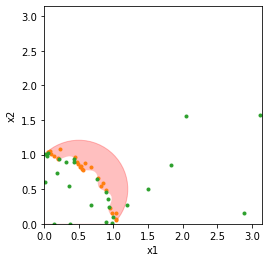

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

theta = np.linspace(0, np.pi / 2)
r = np.sqrt(1 + 0.1 * np.cos(16 * theta))
x_1 = r * np.sin(theta)
x_2_lower = r * np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5) ** 2) ** 0.5 + 0.5

z = np.zeros_like(x_1)

# ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc="white")
circle = plt.Circle(
    (0.5, 0.5), 0.5 ** 0.5, color="r", alpha=0.25, zorder=0, label="Valid Region"
)
ax.add_patch(circle)
history = pd.concat(
    [X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False
)


ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

### Plot path through input space

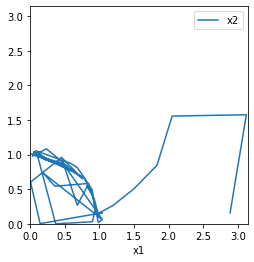

In [5]:
ax = history.plot("x1", "x2")
ax.set_ylim(0, 3.14)
ax.set_xlim(0, 3.14)
ax.set_aspect("equal")

C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[[0.83437913 0.50374126]]


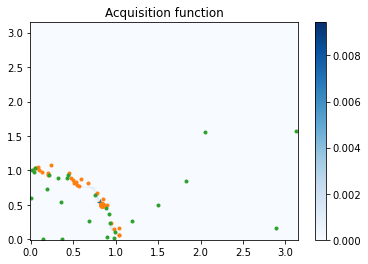

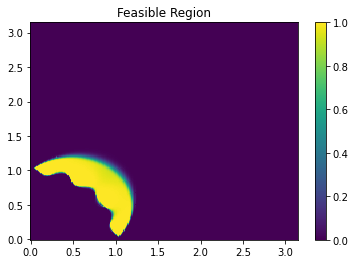

In [7]:
# plot the acquisition function
from xopt.generators.bayesian.utils import feasibility

bounds = generator.vocs.bounds
model = generator.model

# create mesh
n = 200
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

acq_func = generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n), cmap="Blues")
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
    ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

    ax.plot(*history[["x1", "x2"]].to_numpy()[-1].T, "+")

    feas = feasibility(pts.unsqueeze(1), model, generator.sampler, tnk_vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")

candidate = generator.generate(1)
print(candidate[["x1", "x2"]].to_numpy())
ax.plot(*candidate[["x1", "x2"]].to_numpy()[0], "o")

In [7]:
candidate = generator.generate(1)